# Code for loading and modifying datasets

In [1]:
# Utilities
from tqdm import tqdm_notebook as tqdm
import os
import pdb
import glob

# Numerical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning (Q1)
from sklearn.linear_model import Ridge as Ridge
from sklearn.linear_model import LinearRegression as OLS
from sklearn.metrics import mean_squared_error as mse

# Machine Learning (Q2)
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.linear_model import LogisticRegression as LR # 

# Plots
%matplotlib notebook

In [2]:
data_path = "C:/Users/allen/Documents/OSCAR_Data-pulseox-data"
print(os.listdir(data_path))
example = os.path.join(data_path, 'OSCAR_allen_Details_2019-10-24.csv')

['OSCAR_allen_Details_2019-10-08.2.xlsx', 'OSCAR_allen_Details_2019-10-08.3.csv', 'OSCAR_allen_Details_2019-10-24.csv', 'OSCAR_allen_Details_2019-10-24.xlsx', 'OSCAR_allen_Details_2019-10-24_labels.txt', 'OSCAR_allen_Details_2019-10-26.csv', 'OSCAR_allen_Details_2019-10-26_labels.txt', 'Preferences.xml', 'Profiles', 'profiles.xml']


In [3]:
# Data Loading
def day_to_df(path):
    '''
    @args:
        path: os.path object representing path to OSCAR csv file to parse
    @return:
        return: tuple(sp02, pulse, start_time),
        sp02 = pd.DataFrame of SP02 data
        pulse = pd.DataFrame of Pulse data
        start_time = UTC start time in s
    '''
    df = pd.read_csv(path)
    time = df['Session'][0]
    df = df.drop(columns='Session')
    df['DateTime'] -= time # All times start from 0 for session
    
    sp02 = df[df['Event'] == 'SPO2']
    sp02 = sp02.drop(columns='Event')
    
    pulse = df[df['Event'] == 'Pulse']
    pulse = pulse.drop(columns='Event')

    pulse = pulse.reset_index(drop=True)
    sp02 = sp02.reset_index(drop=True)
    del df
    return sp02, pulse, time

In [4]:
# Waveform Manipulations
def impute_wave(wave):
    '''
    @info:
        impute missing values in waveform
    @args:
        wave: np array with floats corresponding to waveform
    @return:
        None, modifies waveform array in place
    '''
    n = wave.shape[0]
    j = 0
    step = None
    for i in range(n-1):
        if i >= j and wave[i+1] == 0:
            j = i+1
            while j < n and wave[j] == 0:
                j += 1
            if j < n:
                step = float(wave[j] - wave[i]) / float(j-i+1)
        elif wave[i] == 0:
            wave[i] = wave[i-1]+step

def moving_avg(wave, N):
    '''
    @info:
        run moving average filter kernal of size N over the wave
    @params:
        wave: np array if size > N
        n: int, the size of the filter kernal
    @return:
        nothing, modifies wave in place
    '''  
    n = wave.shape[0]
    if N > n or N%2 != 1:
        print("Filter kernal needs to be odd sized.")
        return
    running_sum = np.sum(wave[:N])
    N2 = N//2
    for i in range(N2, n - N2 - 1):
        wave[i] = float(running_sum) / float(N)
        running_sum -= wave[i-N2]
        running_sum += wave[i+N2+1]
    # cumsum = np.cumsum(np.insert(wave, 0, 0)) 
    # return (cumsum[N:] - cumsum[:-N]) / float(N)
            

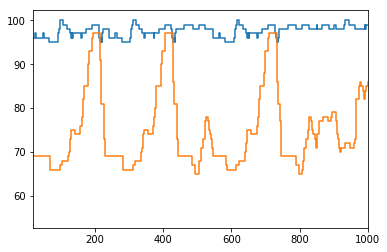

In [5]:
sp02, pulse, start_time = day_to_df(example)
# print(sp02.head(2))
# print(pulse.head(2))
# print(start_time)
plt.clf()
plt.plot(sp02['DateTime'].values, sp02['Data/Duration'].values)
plt.plot(pulse['DateTime'].values, pulse['Data/Duration'].values)
plt.xlim(20, 1000)
plt.savefig(os.path.split(example)[-1] + '.png')
# 74720 time units for 32 minutes


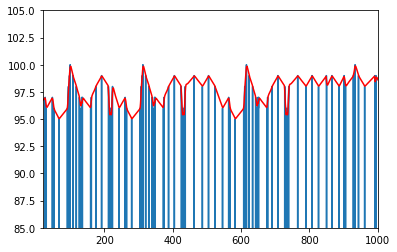

In [18]:

# Pre Processing for the FFT
sp02_fft = np.zeros(np.max(sp02['DateTime'])+1)
sp02_fft[sp02['DateTime']] = sp02['Data/Duration']

wave = np.array(sp02_fft, copy=True)
impute_wave(wave)
moving_avg(wave, 3)

isPlot = True

if isPlot:
    plt.clf()
    plt.plot(np.arange(sp02_fft.shape[0]), sp02_fft)
    plt.plot(np.arange(sp02_fft.shape[0]), wave, 'r')
    plt.xlim(20, 1000)
    plt.ylim(85, 105)
#     plt.savefig('pre-fft.png')


In [34]:
def gen_fft(wave, kernel_size=256, isPlot=False, plots=None):
    '''
        @params:
            wave: numpy array (n,), containing the waveform to generate the FFT for
            kernel_size: int, between 1 and n, size of the FFT window that will slide over the wave, should be power of 2
            isPlot: bool, if true, produce graphs of output
            plots: list, intervals to be printed if isPlot is true
        @returns:
            list (n//kernel_size, 2) containing, each row contains 2 np arrays of size 
            (kernel_size) containing magnitude and phase angle respectively, i.e. [[magnitude, phaseangle],...]
    '''
    # size = 128 # Size of FFT kernel
    interval = 2 # section of waveform being processed
    if plots:
        plots = set(plots)
    else:
        plots = set()
    wave_length = wave.shape[0]
    last_section = wave_length // kernel_size
    result = []
    for interval in tqdm(range(last_section)):
        section = wave[interval*kernel_size:(interval+1)*kernel_size]
        sp = np.fft.fft(section)
        t = np.arange(sp.shape[0]) 
        tlen = len(t)//2
        if isPlot and interval in plots:
            plt.clf()
            plt.title("Raw Post-FFT Data, Interval: {}".format(interval))
            plt.plot(t, sp.real, t, sp.imag)
            plt.ylim(-100, 100)
            plt.xlim(-5, tlen) # Second half of FFT is duplicate info
            plt.show()
            plt.clf()

        # Extract magnitude and angle info
        real = sp.real[:tlen]
        imag = sp.imag[:tlen]
        magnitudes = np.sqrt((real)**2 + (imag)**2)
        angles = np.arctan2(imag, real)
        result.append([magnitudes, angles])

    return result

def plot_fft(magnitudes, angles, offset=1):
    '''
    Plot the given np arrays of magnitude and phase angle, 
    with an optional offset (i.e. to ignore DC component offset=1)
    '''
    ts = np.arange(magnitudes.shape[0])[offset:]
    # Ignoring DC component which is very large
    plt.plot(ts, magnitudes[1:])
    plt.title("Magnitudes Squared")
    plt.show()
    plt.clf()

    plt.plot(ts, angles[1:])
    plt.title("Phase Angles")
    plt.show()
    plt.clf()

In [35]:
result = gen_fft(wave, 128)


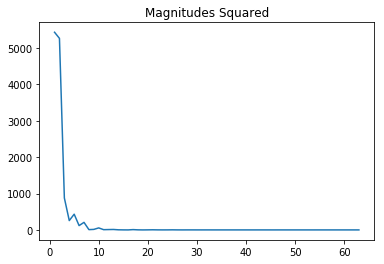

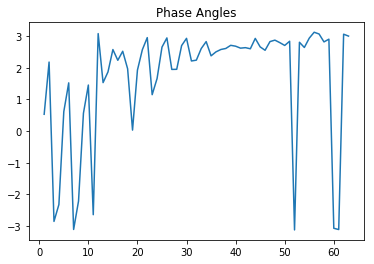

<Figure size 432x288 with 0 Axes>

In [36]:
magnitudes, angles = result[0]
plot_fft(magnitudes, angles)